# Bootstrap Distribution and Confidence Intervals

Alternatives to reporting $p$-values include providing a characterization of the full  distribution of the test statistic under the null hypothesis and reporting a confidence interval, which provides a range that characterizes the most likely values of the test statistic. We start with the distribution of the test statistic under the null hypothesis.

## Bootstrap Distribution

If we perform bootstrap sampling and create sample values of the test statistic, then the set of those values can be used to characterize the distribution of the test statistic.

````{card}
DEFINITION
^^^
```{glossary}
bootstrap distribution
    For some statistic of sample data, the *bootstrap distribution* is a characterization of the possible values of that statistic and the mapping of probability to those values that arises from creating values of that statistic via bootstrap sampling. Whereas the sampling distribution is based on samples from the original random distribution, the bootstrap distribution is based on resampling from a fixed set of data.
```
````
(Note that the term *distribution* is defined more precisely when we define random variables in {doc}`Chapter 8<../08-random-variables/intro>`.)
In this chapter, we will study the bootstrap distribution using histograms.  

We will revisit our test on median wealth using the NLSY79 data set to illustrate these ideas. After loading the necessary libraries and data, we will modify our previous simulation to save every sample value of the test statistic. An efficient way to do this is to create an array of zeros (to preallocate all the needed storage space) and then fill in the appropriate value of the array at each iteration of the simulation:




In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr



In [81]:
import pandas as pd
repo = 'https://raw.githubusercontent.com/jmshea/Foundations-of-Data-Science-with-Python/'
df = pd.read_csv(repo + 'main/05-binary-hypothesis-testing/nls/nls.csv')
remap = {'R0000100':'CASE_ID',
         'T5597600': 'GENDER',
         'T5684500': 'NET_WEALTH',
         'T9900000': 'HIGHEST_GRADE_EVER'
        }
df.rename(columns=remap, inplace=True)
df2 = df[(df['HIGHEST_GRADE_EVER']>0 ) & (df['NET_WEALTH']>0) ].copy()

# Filter on highest grade ever completed and then save the NET_WEALTH column into a new variable 
# (it will be a Pandas Series, which acts much like a DataFrame)
undergrad = df2.query('HIGHEST_GRADE_EVER >= 16 & HIGHEST_GRADE_EVER <=17')['NET_WEALTH']                
grad = df2.query('HIGHEST_GRADE_EVER >= 18')['NET_WEALTH']



In [84]:
num_sims = 10_000
test_statistics = np.zeros(num_sims)

# Define these to avoid having to keep calling a function to get them in every iteration
grad_len = len(grad)
undergrad_len = len(undergrad)

for sim in range(num_sims):
  undergrad_sample = npr.choice(pooled, undergrad_len)
  grad_sample = npr.choice(pooled, grad_len)

  # Calculate the sample value of the test statistic
  sample_diff = np.median(grad_sample) - np.median(undergrad_sample)
  
  # Now we store the value of the test statistic instead of doing a one-sided test
  test_statistics[sim] = sample_diff

Given the array of test statistics, let's start by generating a histogram with 40 bins:

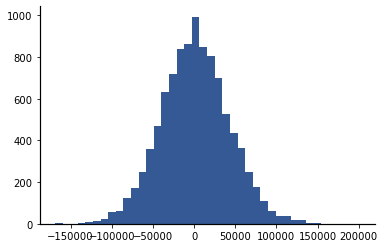

In [106]:
plt.hist(test_statistics, bins=40);

Because so many of the values are large, let's plot in thousands of dollars, which we will abbreviate $K:

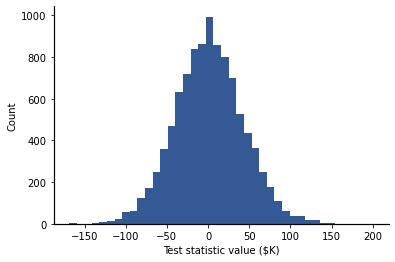

In [107]:
plt.hist(test_statistics/1000, bins=40);
plt.xlabel('Test statistic value ($K)');
plt.ylabel('Count');

This is the shape of the bootstrap distribution. We can immediately make a few observations:
* The distribution is (approximately) symmetric around zero. This should be expected, because under the null hypothesis, the two data from each group is coming from the same distribution. Thus, any differences are equally likely to be positive or negative.
* Almost all of the values are in the interval $[-150, 150]$, with the majority of the values in $[-100, 100]$.

Let's add a line to the histogram to denote the value of the test statistic that we observed in the data. We can draw a vertical line using the matplotlib function `plt.axvline()`:

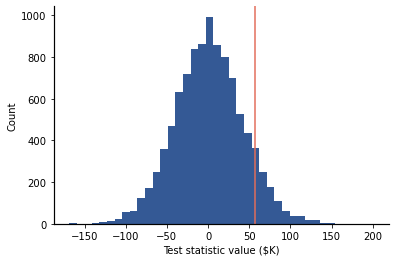

In [108]:
plt.hist(test_statistics/1000, bins=40);
plt.xlabel('Test statistic value ($K)');
plt.ylabel('Count');
# Draw a vertical line at the observed value of the test statistic
plt.axvline(57.4, color='C1');

Then the $p$-value for the one-sided test is the proportion of values in the sampling distribution that are to the right of the orange line. It is hard to infer the value of $p$ from a traditional histogram. However, we can pass a couple of keyword parameters to `plt.hist()` that will make it easier to find the $p$-value:
* `cumulative = True` will make the value accumulate from left to right, and
* `density = True` will normalize the histogram. With the `cumulative = True` option, the results is that the $y$-axis value corresponding to any point on the $x$-axis will be the proportion of values that are less than that $x$-axis value.

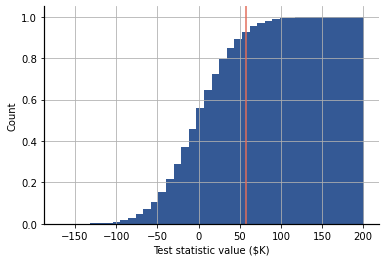

In [109]:
plt.hist(test_statistics/1000, bins=40, cumulative = True, density = True);
plt.xlabel('Test statistic value ($K)');
plt.ylabel('Count');
# Draw a vertical line at the observed value of the test statistic
plt.axvline(57.4, color='C1');
plt.grid();

If we zoom in to the upper right quadrant, we will see the following:

(0.5, 1.0)

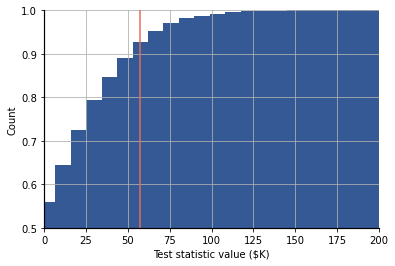

In [110]:
plt.hist(test_statistics/1000, bins=40, cumulative = True, density = True);
plt.xlabel('Test statistic value ($K)');
plt.ylabel('Count');
# Draw a vertical line at the observed value of the test statistic
plt.axvline(57.4, color='C1');
plt.grid();
plt.xlim(0,200);
plt.ylim(0.5, 1)

The proportion less than 57,400 is approximately 0.92, which means that the probability of the test statistic being greater than 57,400 under the null hypothesis is approximately 0.08. 

## Confidence Intervals 

Confidence intervals provide a method of capturing more information about the distribution of the test statistic under the null hypothesis. Recall that the *distribution* characterizes the possible values of the test statistic and the mapping of probability onto those values.[^distribution]  We will characterize the distribution of the test statistic through its histogram. Then confidence intervals give information about 

Let's return to the example introduced in {doc}`nhst`. We want to use data from the National Longitudinal Survey of Youth 1979 (NLSY79) to answer questions about whether post-baccalaureate education increases family wealth. In particular, we asked two questions:
1. Is the observed increase in median wealth ($\Delta = 57,400$) between the undergrad and grad groups statistically significant?
2. Is the observed increase in the relative frequency of millionaires between the undergrad and grad groups ($\Delta \approx 0.053$) statistically significant?

Now that we have a more detailed understanding of how we calculate $p$-values, one- and two-sided tests, and different approaches to sample from the pooled, data, we are ready to answer these questions.

First, let's load the libraries we will need:

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr


Now load the data, filter out those entries that do not have valid data, and create our `undergrad` and `grad` subsets:

In [43]:
import pandas as pd
repo = 'https://raw.githubusercontent.com/jmshea/Foundations-of-Data-Science-with-Python/'
df = pd.read_csv(repo + 'main/05-binary-hypothesis-testing/nls/nls.csv')
remap = {'R0000100':'CASE_ID',
         'T5597600': 'GENDER',
         'T5684500': 'NET_WEALTH',
         'T9900000': 'HIGHEST_GRADE_EVER'
        }
df.rename(columns=remap, inplace=True)
df2 = df[(df['HIGHEST_GRADE_EVER']>0 ) & (df['NET_WEALTH']>0) ].copy()

# Filter on highest grade ever completed and then save the NET_WEALTH column into a new variable 
# (it will be a Pandas Series, which acts much like a DataFrame)
undergrad = df2.query('HIGHEST_GRADE_EVER >= 16 & HIGHEST_GRADE_EVER <=17')['NET_WEALTH']                
grad = df2.query('HIGHEST_GRADE_EVER >= 18')['NET_WEALTH']


Let's create the pooled data by selecting those rows where the respondent had at least 16 years of education. Because all of our tests are on the `NET_WEALTH` variable, we put only that column into our pooled data:

In [44]:
pooled = df2.query('HIGHEST_GRADE_EVER >= 16')['NET_WEALTH']

For research question 1, the test statistic will be the observed difference in medians for the two groups. Let's compute this difference and store it in a variable:

In [46]:
delta1 = grad.median() - undergrad.median()
print(f'Observed difference in median net family wealth was {delta1}')

Observed difference in median net family wealth was 57400.0


For research question 2, we are computing the proportion of families with net wealth over \$1,000,000. Because we will be computing these proportions repeatedly during our statistical test, let's make a helper function to do the computation:

In [52]:
def find_proportion(data, thresh=1_000_000):
  return np.sum(data >= thresh) / len(data) 

The test statistic is the difference in observed values of the proportion of millionaires between the grad and undergrad populations. Let's compute that difference and store it in a variable:

In [55]:
delta2 = find_proportion(grad) - find_proportion(undergrad)
print(f'Observed difference in proportion of millionaires is {delta2}')

Observed difference in proportion of millionaires is 0.05327386547112914


Now we are ready to plan our resampling tests:

**First, we need to decide whether to perform a one-sided or two-sided test.** Because the overall question is  "Whether  Post-Baccalaureate Education Increases Family Wealth", a one-sided test makes sense. If instead the question was "Does Post-Baccalaureate Education Affect Family Wealth", then a two-sided test would have been more appropriate. 

**Second, we need to decide how we will do resampling.** Because we are going to perform a NHST on sample values of the test statistic, a bootstrap test is justified and is the test that is most commonly used in this type of test. Thus, we will use a bootstrap test. Note, however, that a Monte Carlo permutation test is not wrong, because we are performing a test where we are trying to remove the effect of difference in treatment (the highest grade completed).

## One-sided Bootstrap Test on Difference of Medians

Our simulation will follow the form in {doc}`nhst`. In each iteration, we:
* Draw new groups from the pooled data to represent randomly chosen `undergrad` and `grad` groups. The samples are drawn *with replacement* using the default behavior of `npr.choice()`.
* Find the sample value of the test statistic, compare it to the observed value, and increment a counter if it is as extreme as the observed value. Because we are conducting a one-sided test, we will increment the counter if the sample value of the test statistic is *at least as large* as the observed value.

At the end of the simulation, we print out the relative frequency of the test statistic being as large as the value observed in the data. 

```{note}

**Choosing the number of simulation iterations for NHST**

To accurately estimate the probability of some event via simulation, we usually need to conduct enough simulations to capture around 100 occurrences of that event. If the event occurs with probability $p$, we need approximately $100/p$ iterations in our simulation.

However, for a NHST, we do not necessarily need to accurate estimate the probability of the event -- we only need to determine if the probability is close to our significance threshold.  If the probability is very close to our threshold, then we want enough simulations to determine whether the probability is above or below the threshold. Since the significance threshold is usually 0.05 or 0.01, then **we need around $100/(0.01) = 10,000$ simulations**.
```

Here is a simulation based on the discussion above:

In [67]:
num_sims = 10_000
count=0

# Define these to avoid having to keep calling a function to get them in every iteration
undergrad_len = len(undergrad)
grad_len = len(grad)


for sim in range(num_sims):
  # Create random groups under H0 using bootstrap sampling:
  undergrad_sample = npr.choice(pooled, undergrad_len)
  grad_sample = npr.choice(pooled, grad_len)

  # Calculate the sample value of the test statistic
  sample_diff = np.median(grad_sample) - np.median(undergrad_sample)
  
  # Increment the counter based on the one-sided test
  if sample_diff >= delta1:
    count+=1


print(f'The p-value (the proportion of test statistics as extreme as observed in the data) is {count/num_sims}')

The p-value (the proportion of test statistics as extreme as observed in the data) is 0.0915


**Since  $p \approx 0.09$ is over our threshold of 0.05, we cannot reject the null hypothesis.** This does not mean that the observed difference in median net wealth is not real; it only means that there is not enough data to be confident that the difference is simply a result of random effects and  limited sample sizes.

```{note}

Always report the measured $p$-value along with the conclusion. It is not sufficient to just report $p>0.05$ because the specific $p$ value gives additional insight into the results of the statistical test. 
```

## One-sided Bootstrap Test on Proportion of Millionaires


The simulation for research question 2 is almost identical to that for research question 1. The only changes are in calculating the test statistic and the threshold to which the test statistic is compared.

In [79]:
num_sims = 10_000
count=0

# Define these to avoid having to keep calling a function to get them in every iteration
grad_len = len(grad)
undergrad_len = len(undergrad)

for sim in range(num_sims):
  # Create random groups under H0 using bootstrap sampling:
  undergrad_sample = npr.choice(pooled, undergrad_len)
  grad_sample = npr.choice(pooled, grad_len)
  
  # The test statistic for research question 2 is the difference in 
  # proportions of millionaires
  sample_diff = find_proportion(grad_sample) - find_proportion(undergrad_sample)
  
  # The test statistic is compared to the difference in proportions of
  # millionaires that was observed in the original data
  if sample_diff >= delta2:
    count+=1
print(f'The p-value (the proportion of test statistics as extreme as observed in the data) is {count/num_sims}')

The p-value (the proportion of test statistics as extreme as observed in the data) is 0.0181


Since the $p$-value is less than our specified significance threshold of 0.05, we say that we **reject the null hypothesis at the $p<0.05$ level, since $p \approx 0.02$.** Thus, although the observed difference in median net wealth among the groups was not found to be statistically significant, the observed difference in proportions of millionaires was found to be statistically significant. 


```{note}

When applying multiple NHSTs using the same data set, a stricter criteria should be applied 
to ensure statistical significance at a given level. However, the details are beyond
the scope of this book. Observing a value of $p \approx 0.02$ is still sufficient to ensure
at the $p < 0.05$ level.
```


One (of many) criticisms of NHSTs is that they throw away a lot of information about the test by only calculating and reporting a single number, the $p$-value. In the next section, we show how we can use the entire set of sample values of the test statistic to create confidence intervals that capture more information about the statistical test 